In [65]:
import os
import xml.etree.ElementTree as ET
import warnings
from PIL import Image
import pandas as pd 


In [66]:
def getdata(path):
    # Create paths
    images_path = [] 
    annotations_path = []
    #Divice path follow type
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            file_path = os.path.join(dirname, filename)
            if file_path[-3:] == 'xml':
                annotations_path.append(file_path)
            else:
                images_path.append(file_path)
    #check if loaded all data
    if len(images_path) == 853:
        print("Ok Load done")
    else:
        print("Not Ok...")
    return annotations_path,images_path

def dfmode(annotations_path):
    #create dataframe to save data
    df=pd.DataFrame(columns=['xmin','xmax','ymin','ymax','file_name','label'])
  
    for xml_file in annotations_path:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        file_name = root.find('filename').text
          
    # foreach object
        for obj in root.findall('object'):
            r = {
                'xmin': int(obj.find('bndbox').find('xmin').text),
                'ymin': int(obj.find('bndbox').find('ymin').text),
                'xmax': int(obj.find('bndbox').find('xmax').text),
                'ymax': int(obj.find('bndbox').find('ymax').text),
                'file_name': file_name,
                'label': obj.find('name').text,
            }
            # Encode label
            # 0 = without_mask
            # 1 = with_mask
            # 2 =  mask_weared_incorrect

            if (r['label']=='without_mask'):
                    r['label']=0
            elif (r['label']=='with_mask'):
                    r['label']=1
            else:
                    r['label']=2
            df = df.append(r, ignore_index=True)
    return df

Get data from path, return annotations path and images path. Get information from annototions and save to dataframe

In [67]:
annotations_path,images_path=getdata('E:/UwayInternshipLearning/FaceMaskDetection/Face-Mask-Detection/input')
df=dfmode(annotations_path)


Ok Load done


C:\Users\Admin\AppData\Local\Temp\ipykernel_8164\3608491269.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(r, ignore_index=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8164\3608491269.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(r, ignore_index=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8164\3608491269.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(r, ignore_index=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8164\3608491269.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(r, ignore_index=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_

In [68]:
df.head()

,xmin,xmax,ymin,ymax,file_name,label
0,79,109,105,142,maksssksksss0.png,0
1,185,226,100,144,maksssksksss0.png,1
2,325,360,90,141,maksssksksss0.png,0
3,321,354,34,69,maksssksksss1.png,1
4,224,261,38,73,maksssksksss1.png,1


Devide data to train, test, valid set

In [69]:
def train_test_valid_split(df):
    Ytest=df.sample(frac=0.1, replace=False)
    Xtest=pd.DataFrame(columns=['file_name'])   
    Xtest=Ytest.pop('file_name')

    Yvali=df.sample(frac=0.1,replace=False)
    Xvali=pd.DataFrame(columns=['file_name'])
    Xvali=Yvali.pop('file_name')

    Ytrain=df.sample(frac=0.8,replace=False)
    Xtrain=pd.DataFrame(columns=['file_name'])
    Xtrain=Ytrain.pop('file_name')

    return  Xtrain,Ytrain,Xtest,Ytest,Xvali,Yvali
    
    
train_X, train_Y, test_X, test_Y, val_X, val_Y=train_test_valid_split(df)

In [70]:
print('train_X.shape =', train_X.shape)
print('train_Y.shape =', train_Y.shape)
print('val_X.shape   =', val_X.shape)
print('val_Y.shape   =', val_Y.shape)
print('test_X.shape  =', test_X.shape)
print('test_Y.shape  =', test_Y.shape)

train_X.shape = (3258,)
train_Y.shape = (3258, 5)
val_X.shape   = (407,)
val_Y.shape   = (407, 5)
test_X.shape  = (407,)
test_Y.shape  = (407, 5)


In [71]:
train_Y.head()

,xmin,xmax,ymin,ymax,label
2220,133,157,82,109,1
3381,19,37,89,107,1
1911,134,148,63,82,1
523,144,276,99,219,1
1400,298,314,39,57,1


Path in images_path include path for 853 image. We need the path to images corresponding with each face, each sample in test,training,valid set 

In [72]:
path='E:/UwayInternshipLearning/FaceMaskDetection/Face-Mask-Detection/input'

path_to_train_X=[]
path_to_val_X=[]
path_to_test_X=[]

for dirname, _,_ in os.walk(path):
    if dirname[-6:]=='images':
        for i in train_X:
            file_path=os.path.join(dirname,i)  
            path_to_train_X.append(file_path)  
        for i in val_X:
            file_path=os.path.join(dirname,i)
            path_to_val_X.append(file_path)
        for i in test_X:
            file_path=os.path.join(dirname,i)
            path_to_test_X.append(file_path)
            


In [73]:
df['label'].value_counts()


1    3232
0     717
2     123
Name: label, dtype: int64

Crop faces from image for training

In [74]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [75]:
def crop(frame_pos,path_image:list,new_size):
    xmin=[]
    xmax=[]
    ymin=[]
    ymax=[]

    for i in frame_pos['xmin']:
        xmin.append(i)
    for i in frame_pos['xmax']:
        xmax.append(i)
    for i in frame_pos['ymin']:
        ymin.append(i)
    for i in frame_pos['ymax']:
        ymax.append(i)

    arr_img=[]

    for i in range(len(path_image)):
        im=Image.open(path_image[i])
        im=im.convert('RGB')
        im_arr=np.array(im)
        im_arr=im_arr[ymin[i]:ymax[i],xmin[i]:xmax[i],:]
        image=Image.fromarray(im_arr)
        image=image.resize(new_size)
        arr_img.append(image)
    
    return arr_img
    

In [76]:
new_size=50,50
train_X_set=crop(train_Y,path_to_train_X,new_size)
val_X_set=crop(val_Y,path_to_val_X,new_size)
test_X_set=crop(test_Y,path_to_test_X,new_size)

Drop box information out of Y dataset

In [77]:
def del_box_infor(dtaframe):
    del dtaframe['xmin']
    del dtaframe['xmax']
    del dtaframe['ymin']
    del dtaframe['ymax']

del_box_infor(train_Y)
train_Y            

,label
2220,1
3381,1
1911,1
523,1
1400,1
...,...
3967,1
2999,1
2889,0
3578,0


Let see the result

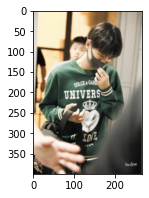

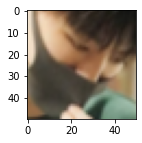

<PIL.Image.Image image mode=RGB size=50x50 at 0x17CC74CFF40>


In [78]:
im=Image.open(path_to_train_X[30])
plt.figure(figsize=(3,3))
plt.imshow(im)
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(train_X_set[30])
plt.show()

print(train_X_set[10])

Build  Basic CNN Model

In [105]:
import numpy as np
from activations import *
from cnn import*
from flatten import*
from fully_conected import*
from handle_data import *
from loss import *
from normalize import *
from Pooling import*

In [79]:
train_Y

,label
2220,1
3381,1
1911,1
523,1
1400,1
...,...
3967,1
2999,1
2889,0
3578,0


In [ ]:
train_Y=train_Y.to_numpy()

In [94]:
train_Y

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=object)

In [97]:
np.unique(train_Y)

array([0, 1, 2], dtype=object)

In [100]:
def train_cnn(epochs,batch,train_X,train_Y,val_X,val_Y):
    K=len(np.unique(train_Y))
    one_hot_Y = np.zeros((len(train_Y),K))
    for i in range(len(train_Y)):
        if(train_Y[i]==0):
            one_hot_Y[i][0]=1
        elif(train_Y[i]==1):
            one_hot_Y[i][1]=1
        else:
            one_hot_Y[i][2]=1
    
    errs = [] # To save mean binary errors on training set during training
    val_errs = [] # To save mean binary errors on validation set during training
    N = len(train_X) # Num training pairs
    W1=np.array[
        [-1,0,1]
        [-2,0,2]
        [-1,0,1]
    ]
    W1=np.array[
        [1,2,1]
        [0,0,0]
        [-1,-2,-1]
    ]
    b=np.ones()
    W2=np.array[
        [-1,0,0,0,1]
        [-1,0,0,0,1]
        [-1,0,0,0,1]
        [-1,0,0,0,1]
        [-1,0,0,0,1]
    ]

    for epoch in range(epochs):
        for strart_indx in range(0,N,batch):
            convolution(train_X[i],W1,0,1,)
            
    

In [101]:
train_cnn(5,17,train_X,train_Y,val_X,val_Y)

[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]